In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install deap

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.6/135.6 kB 3.3 MB/s eta 0:00:00


In [3]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import time
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score, matthews_corrcoef
import matplotlib.pyplot as plt
import seaborn as sns
from deap import base, creator, tools, algorithms
import random
import lightgbm as lgb

In [4]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

### Custom mGRU Cell

In [5]:
class mGRUCell(keras.layers.Layer):
    def __init__(self, units, **kwargs):
        self.units = units
        self.state_size = units
        self.output_size = units
        super(mGRUCell, self).__init__(**kwargs)

    def build(self, input_shape):
        self.W_z = self.add_weight(shape=(input_shape[-1], self.units), initializer='glorot_uniform', name='W_z')
        self.b_z = self.add_weight(shape=(self.units,), initializer='zeros', name='b_z')
        self.W_h = self.add_weight(shape=(input_shape[-1], self.units), initializer='glorot_uniform', name='W_h')
        self.b_h = self.add_weight(shape=(self.units,), initializer='zeros', name='b_h')
        self.built = True

    def call(self, inputs, states):
        h_prev = states[0]
        z = tf.sigmoid(tf.matmul(inputs, self.W_z) + self.b_z)
        h_tilde = tf.tanh(tf.matmul(inputs, self.W_h) + self.b_h)
        h = (1 - z) * h_prev + z * h_tilde
        return h, [h]

### Load and preprocess dataset

In [6]:
def load_and_preprocess_data(dataset_path):
    dataset = pd.read_csv(dataset_path)
    df = dataset.copy()
    df.loc[df['label'] != 'Benign', 'label'] = 'Attack'
    df = df.dropna()
    X = df.iloc[:, :-2].values
    y = df.iloc[:, -1].values
    if not np.issubdtype(y.dtype, np.number):
        y = (y != 'Benign').astype(int)
    scaler = MinMaxScaler()
    X = scaler.fit_transform(X)
    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.3, random_state=42)
    return X_train, y_train, X_val, y_val, X_test, y_test

### Fitness function using LightGBM for binary classification

In [7]:
def fitness(individual, X_train, y_train, X_val, y_val):
    selected_features = [i for i, bit in enumerate(individual) if bit]
    if not selected_features:
        return 0,
    X_train_selected = X_train[:, selected_features]
    X_val_selected = X_val[:, selected_features]
    model = lgb.LGBMClassifier(objective='binary', metric='binary_logloss', verbosity=-1)
    model.fit(X_train_selected, y_train)
    y_pred = model.predict(X_val_selected)
    accuracy = accuracy_score(y_val, y_pred)
    return accuracy,

### Build mGRU model for binary classification

In [17]:
def build_mgru_model(num_features):
    model = keras.Sequential([
        keras.layers.RNN(mGRUCell(128), return_sequences=True, input_shape=(1, num_features)),
        keras.layers.RNN(mGRUCell(64), return_sequences=True),
        keras.layers.RNN(mGRUCell(32), return_sequences=False),
        keras.layers.Dense(1, activation='sigmoid')
    ])
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

### Main execution

In [9]:
dataset_path = '/content/drive/MyDrive/multi-vector-IDS/code/CICIoMT2024/CICIoMT2024_test_balanced.csv'

In [10]:
X_train, y_train, X_val, y_val, X_test, y_test = load_and_preprocess_data(dataset_path)

### Genetic Algorithm setup

In [11]:
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)
toolbox = base.Toolbox()
toolbox.register("attr_bool", random.randint, 0, 1)
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_bool, n=X_train.shape[1])
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("evaluate", fitness, X_train=X_train, y_train=y_train, X_val=X_val, y_val=y_val)
toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", tools.mutFlipBit, indpb=0.05)
toolbox.register("select", tools.selTournament, tournsize=3)

pop = toolbox.population(n=10)
for gen in range(5):
    offspring = algorithms.varAnd(pop, toolbox, cxpb=0.5, mutpb=0.2)
    fits = toolbox.map(toolbox.evaluate, offspring)
    for fit, ind in zip(fits, offspring):
        ind.fitness.values = fit
    pop = toolbox.select(offspring, k=len(pop))
best_ind = tools.selBest(pop, k=1)[0]
selected_features = [i for i, bit in enumerate(best_ind) if bit]
print(f"Selected features: {len(selected_features)} out of {X_train.shape[1]}")

Selected features: 24 out of 45


In [12]:
df_original = pd.read_csv(dataset_path)
feature_names = df_original.columns[:-2]

selected_feature_names = [feature_names[i] for i in selected_features]
print("Selected Feature Names:")
for name in selected_feature_names:
    print(name)

Selected Feature Names:
Header_Length
Rate
Srate
psh_flag_number
ack_flag_number
cwr_flag_number
syn_count
rst_count
HTTP
HTTPS
Telnet
SMTP
IRC
TCP
ICMP
IGMP
LLC
Tot sum
AVG
Std
Tot size
IAT
Radius
Variance


### Prepare data with selected features

In [13]:
df_selected = df_original[selected_feature_names + ['label', 'category']]
display(df_selected.head())

,Header_Length,Rate,Srate,psh_flag_number,ack_flag_number,cwr_flag_number,syn_count,rst_count,HTTP,HTTPS,...,LLC,Tot sum,AVG,Std,Tot size,IAT,Radius,Variance,label,category
0,0.00,276.382000,276.382000,0.0,0.00,0.0,0.00,0.00,0.0,0.0,...,1.0,441.0,42.00,0.0000,42.00,84679600.0,0.000,0.00,ICMP,1
1,0.00,1.330734,1.330734,0.0,0.00,0.0,0.00,0.00,0.0,0.0,...,1.0,441.0,42.00,0.0000,42.00,84679610.0,0.000,0.00,ICMP,1
2,41975.00,28694.035000,28694.035000,0.0,0.00,0.0,0.00,0.00,0.0,0.0,...,1.0,525.0,50.00,0.0000,50.00,84696910.0,0.000,0.00,UDP,6
3,222.62,0.727629,0.727629,0.0,0.28,0.0,3.72,2.06,0.0,0.0,...,1.0,577.5,54.88,0.8687,55.12,84674750.0,1.228,0.55,SYN,4
4,40525.00,21592.951000,21592.951000,0.0,0.00,0.0,0.00,0.00,0.0,0.0,...,1.0,525.0,50.00,0.0000,50.00,84679170.0,0.000,0.00,UDP,6


In [14]:
output_path = '/content/drive/MyDrive/multi-vector-IDS/code/CICIoMT2024/CICIoMT2024_selected_features_dataset.csv'
df_selected.to_csv(output_path, index=False)

In [15]:
X_train_selected = X_train[:, selected_features].reshape(-1, 1, len(selected_features))
X_test_selected = X_test[:, selected_features].reshape(-1, 1, len(selected_features))

### Train mGRU model

In [18]:
model = build_mgru_model(len(selected_features))
start_time = time.time()
history = model.fit(X_train_selected, y_train, epochs=40, batch_size=1000, validation_data=(X_test_selected, y_test))
training_time = time.time() - start_time

Epoch 1/40
612/612 ━━━━━━━━━━━━━━━━━━━━ 16s 18ms/step - accuracy: 0.9399 - loss: 0.1726 - val_accuracy: 0.9952 - val_loss: 0.0165
Epoch 2/40
612/612 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - accuracy: 0.9955 - loss: 0.0145 - val_accuracy: 0.9970 - val_loss: 0.0091
Epoch 3/40
612/612 ━━━━━━━━━━━━━━━━━━━━ 11s 18ms/step - accuracy: 0.9972 - loss: 0.0088 - val_accuracy: 0.9980 - val_loss: 0.0061
Epoch 4/40
612/612 ━━━━━━━━━━━━━━━━━━━━ 22s 21ms/step - accuracy: 0.9977 - loss: 0.0072 - val_accuracy: 0.9970 - val_loss: 0.0085
Epoch 5/40
612/612 ━━━━━━━━━━━━━━━━━━━━ 19s 18ms/step - accuracy: 0.9977 - loss: 0.0067 - val_accuracy: 0.9981 - val_loss: 0.0072
Epoch 6/40
612/612 ━━━━━━━━━━━━━━━━━━━━ 21s 19ms/step - accuracy: 0.9979 - loss: 0.0060 - val_accuracy: 0.9985 - val_loss: 0.0041
Epoch 7/40
612/612 ━━━━━━━━━━━━━━━━━━━━ 20s 18ms/step - accuracy: 0.9982 - loss: 0.0056 - val_accuracy: 0.9984 - val_loss: 0.0046
Epoch 8/40
612/612 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - accuracy: 0.9983 - loss: 0.0049 - v

### Evaluate

In [19]:
start_time = time.time()
y_pred = model.predict(X_test_selected)
detection_time = (time.time() - start_time) / len(y_test)
y_pred_class = (y_pred > 0.5).astype(int)

2458/2458 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step


### Metrics

In [20]:
cm = confusion_matrix(y_test, y_pred_class)
print("Confusion Matrix:\n", cm)
print(classification_report(y_test, y_pred_class))
tn, fp, fn, tp = cm.ravel()

accuracy = accuracy_score(y_test, y_pred_class)
precision = precision_score(y_test, y_pred_class)
recall = recall_score(y_test, y_pred_class)
f1 = f1_score(y_test, y_pred_class)
specificity = tn / (tn + fp)
far = fp / (fp + tn)
fpr = fp / (fp + tn)
mcc = matthews_corrcoef(y_test, y_pred_class)
sensitivity = tp / (tp + fn)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")
print(f"Specificity: {specificity:.4f}")
print(f"FAR: {far:.4f}")
print(f"FPR: {fpr:.4f}")
print(f"MCC: {mcc:.4f}")
print(f"Sensitivity: {sensitivity:.4f}")

model.save('bce_model.h5')
model_size = os.path.getsize('bce_model.h5') / 1024  # KB
print(f"Model size: {model_size:.2f} KB")
print(f"Training time: {training_time:.2f} seconds")
print(f"Detection time per sample: {detection_time:.6f} seconds")

Confusion Matrix:
 [[11183     4]
 [   29 67427]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     11187
           1       1.00      1.00      1.00     67456

    accuracy                           1.00     78643
   macro avg       1.00      1.00      1.00     78643
weighted avg       1.00      1.00      1.00     78643

Accuracy: 0.9996
Precision: 0.9999
Recall: 0.9996
F1-score: 0.9998
Specificity: 0.9996
FAR: 0.0004
FPR: 0.0004
MCC: 0.9983
Sensitivity: 0.9996
Model size: 364.26 KB
Training time: 625.46 seconds
Detection time per sample: 0.000131 seconds


### Visualization

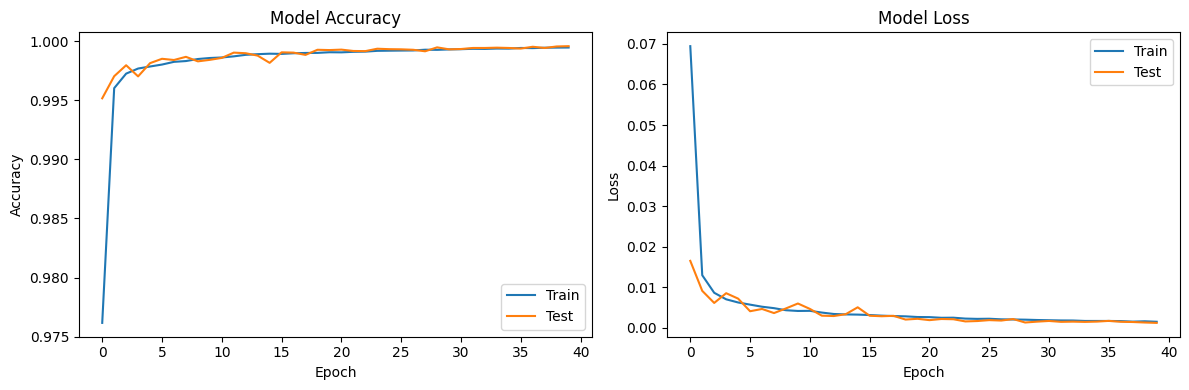

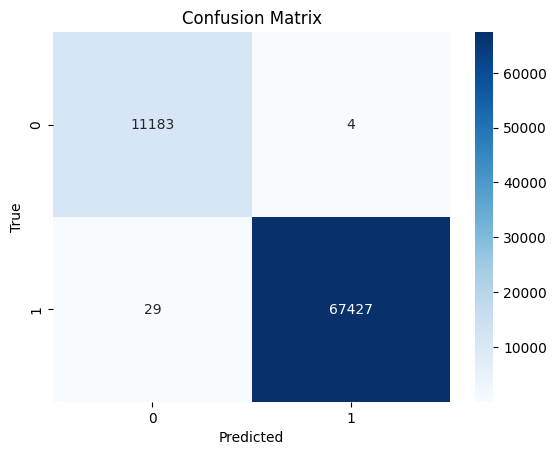

In [21]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Test')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Test')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()

print("\n")

plt.figure()
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()